# Experiments - Frequency Domain Features
- Create standard frequency domain (FD) features for the signature data
- Explore the FD features for predictive potential (correlation with target)
- Perform some quick modelling trials

If modelling on FD alone shows no promise, identify a subset of FD features that could possibly add value to the other classification model (using spectra features).

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import welch
from scipy.stats import entropy
from scipy.stats import gmean
from scipy.signal import find_peaks
from tqdm import tqdm
from sklearn.svm import OneClassSVM
from sklearn import preprocessing

In [2]:
# Training Metadata
metadata_train = pd.read_csv('../metadata_train.csv')
train_signature_count = len(metadata_train)
print('No. of training signatures: ', train_signature_count)

count_undamag = len(metadata_train.loc[(metadata_train['target']==0)])
count_damaged = len(metadata_train.loc[(metadata_train['target']==1)])
print(f'Damaged: {count_damaged} of train_signature_count ({round(100*count_damaged/train_signature_count, 1)}%)')

No. of training signatures:  8712
Damaged: 525 of train_signature_count (6.0%)


In [3]:
# Bring in a sample signature & engineer some standard frequency domain features
id_sig = 14
signal = pq.read_table('../data/train.parquet', columns=[str(id_sig)]).to_pandas()[str(id_sig)].values

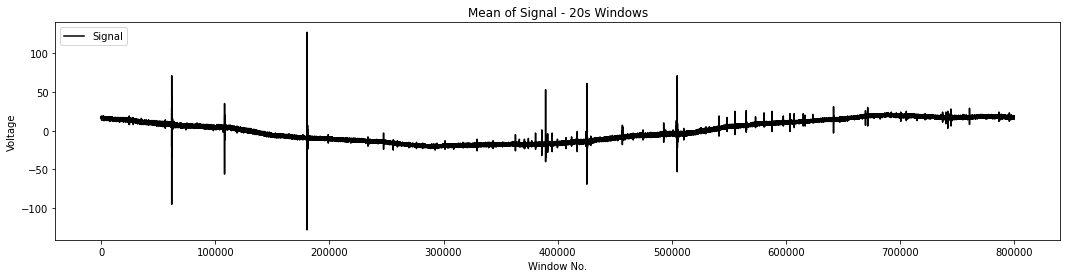

In [4]:
# Plot the compressed signatures for the 1st signal id (800 chunks & mean of raw signal)
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(signal, label='Signal', color = 'black')
ax.legend(loc = "upper left")
plt.ylabel("Voltage")
plt.xlabel("Window No.") 
plt.title("Mean of Signal - 20s Windows")
plt.show()

In [5]:
# Perform Fast Fourier Transform (TD > FD)
fourier_values = fft(signal)
fourier_values.shape

(800000,)

In [6]:
# Convert data to more interpretable output
# N is number of points in our input signal
N=800000

# T is the time period which is inverseof frequency which is 50Hz
T=1/50

# fft_values contains the filtered useful values from fft_values_ vector
fourier_values_filtered = 2.0/N * np.abs(fourier_values[0:N//2])
fvf = fourier_values_filtered

# f_values contains the frquency values
f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)

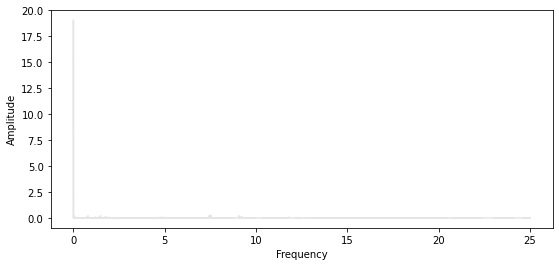

In [7]:
# Plot Amplitude vs Frequency
fig, ax = plt.subplots(figsize = (9, 4))
plt.plot(f_values, fvf, color='gray', alpha = 0.2)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

In [8]:
# Calculate Entropy
entropy(fvf)

12.305380087526698

In [9]:
# Spectral flatness
# Measure of how much a sound resembles a tone, as opposed to being noise-like.
spectrum = abs(fvf)
gmean(spectrum**2)/np.mean(spectrum**2)

0.001052676647812643

In [10]:
# Mean
np.mean(abs(fvf))

0.0013147768479876765

In [11]:
# Median
np.median(abs(fvf))

0.001058587570275721

In [12]:
# Root mean sqaure ???
math.sqrt(np.mean(fvf**2))

0.030273544925330437

In [13]:
# Find peaks
peaks, _ = find_peaks(fvf, height=0)
top10_peaks = sorted([fvf[i] for i in peaks], reverse=True)[0:9]
print(top10_peaks)

[19.052392816974745, 1.2757212626670538, 0.3210977863297654, 0.2689703373715018, 0.20614737272652475, 0.20576362989473226, 0.20508426175692232, 0.20496374756993374, 0.19331680866119827]


In [14]:
# Create a dataframe of Top 100 peaks
freqs = [f_values[i] for i in peaks]
amps = [fourier_values_filtered[i] for i in peaks]
df = pd.DataFrame(freqs, columns = ['freqs'])
df['amps'] = amps
df_tops = df.nlargest(100, 'amps')
df_tops

,freqs,amps
0,0.000063,19.052393
2,0.000438,1.275721
3,0.000688,0.321098
40258,7.462519,0.268970
40725,7.550019,0.206147
...,...,...
957,0.173563,0.026750
24708,4.537074,0.026712
24704,4.536199,0.026448
86,0.015188,0.026367


In [15]:
# Bin the Top 100 data and identify the Top 3 bins for the signal
bins = np.linspace(0, 30, 35)
digitized = np.digitize(df_tops.freqs, bins)
top3_bins = sorted(set(list(digitized)), key = list(digitized).count, reverse = True)[0:3]
top3_bins

[1, 6, 2]

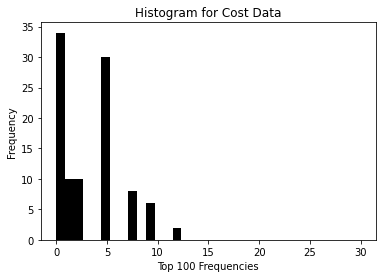

In [16]:
# plot a histogram of the sample (verify calculation above for Top 3 bins)
plt.hist(df_tops.freqs, bins=bins, color='black')
plt.xlabel("Top 100 Frequencies")
plt.ylabel("Frequency")
plt.title("Histogram for Cost Data")
plt.show()

## Frequency Domain Feature Extraction Function

In [17]:
# Now create a function to calculate all these features for the signal data
def extract_fd_features (dat, N = 800000, T=1/50, ):
    
    # N is number of points in our input signal
    # T is the time period which is inverseof frequency which is 50Hz
    
    # Create an empty list to hold calculated features
    features = []
    
    # Create an empty list to hold label names
    labels = []
    
    # Feature dictionary
    feature_dict = {
        'f01':'Entropy',
        'f02':'Spectral flatness',
        'f03':'Mean',
        'f04':'Median',
        'f05':'Root mean square',
        'f06':'Max Amplitude',
        'f07':'2nd Amplitude',
        'f08':'3rd Amplitude',
        'f09':'Max Frequency',
        'f10':'2nd Frequency',
        'f11':'3rd Frequency',
        'f12':'Peaks Frequency Bin 1',
        'f13':'Peaks Frequency Bin 2',
        'f14':'Peaks Frequency Bin 3'
        
    }
    globals()['feature_dict'] = feature_dict
    
    # Loop through and create list of label references
    for freq_feat in range(1, len(feature_dict)+1, 1):
        labels.append(f'f{"{:02d}".format(freq_feat)}')
    
    # fft_values contains the filtered useful values from fft_values_ vector
    fourier_values = fft(dat)
    fvf = 2.0/N * np.abs(fourier_values[0:N//2])

    # f_values contains the frquency values
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    
    # Calculate features in time domain
    # Entropy
    f01 = entropy(fvf)   
    
    # Spectral flatness
    # Measure of how much a sound resembles a tone, as opposed to being noise-like.
    spectrum = abs(fvf)
    f02 = gmean(spectrum**2)/np.mean(spectrum**2)
     
    f03 = np.mean(abs(fvf))          
    f04 = np.median(abs(fvf))      
    f05 = math.sqrt(np.mean(fvf**2))   
    
    # Find peaks
    peaks, _ = find_peaks(fvf, height=0)
    freqs = [f_values[i] for i in peaks]
    amps = [fourier_values_filtered[i] for i in peaks]
    df = pd.DataFrame(freqs, columns = ['freqs'])
    df['amps'] = amps
    df_tops = df.nlargest(100, 'amps')
    bins = np.linspace(0, 30, 35)
    digitized = np.digitize(df_tops.freqs, bins)
    top3_bins = sorted(set(list(digitized)), key = list(digitized).count, reverse = True)[0:3]
    
    f06 = df_tops.amps.iloc[0]      
    f07 = df_tops.amps.iloc[1] 
    f08 = df_tops.amps.iloc[2]             
    f09 = df_tops.freqs.iloc[0]         
    f10 = df_tops.freqs.iloc[1]              
    f11 = df_tops.freqs.iloc[2]             
    f12 = top3_bins[0]  
    f13 = top3_bins[1]  
    f14 = top3_bins[2]  
    
    for feat in range(len(feature_dict)):
        features.append(locals()[f'{list(feature_dict.keys())[feat]}'])
        
    return(features, labels)

In [18]:
# Now loop through the dataset and calculate the features
# Output a dataframe of features per signature
signature_ids = range(train_signature_count)
#signature_ids = range(30)
initialise = True
for signature_id in tqdm(signature_ids):
    signals_train = pq.read_table('../data/train.parquet', columns=[str(signature_id)]).to_pandas()[str(signature_id)].values    
    feature_list, labels = extract_fd_features(signals_train)

    if initialise:
        df = pd.DataFrame([feature_list])
        df.columns = labels
        initialise = False
    else:     
        df_add = pd.DataFrame([feature_list])
        df_add.columns = labels
        df = pd.concat([df, df_add], axis=0)
    #print(feature_list)
    
df.reset_index(inplace = True, drop = True) 

100%|███████████████████████████████████████| 8712/8712 [19:05<00:00,  7.61it/s]


In [22]:
# Add the target (classification label for undamaged/damaged signatures)
df['target'] = metadata_train['target'][0:len(df)]

### Feature Visualisation - Compare Damaged to Undamaged Distributions

In [23]:
df_undamaged = df.loc[(df['target']==0)]
df_damaged = df.loc[(df['target']==1)]

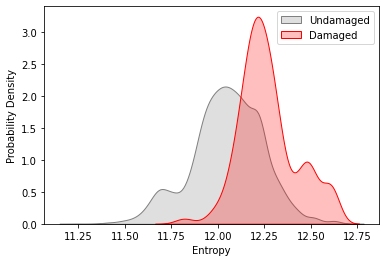

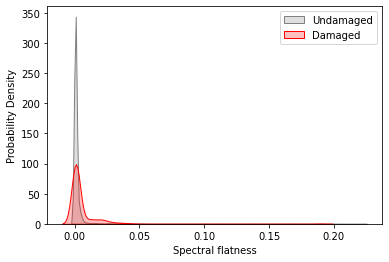

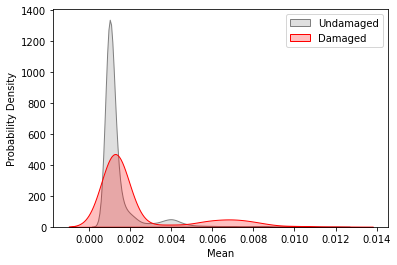

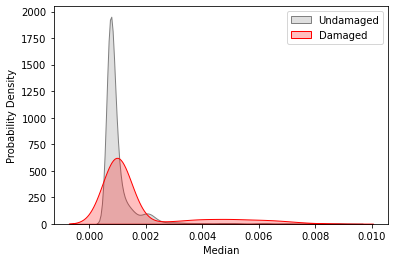

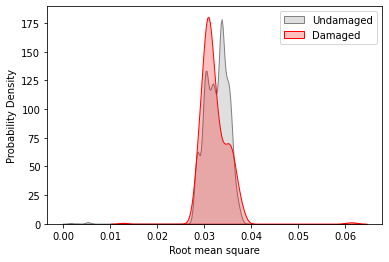

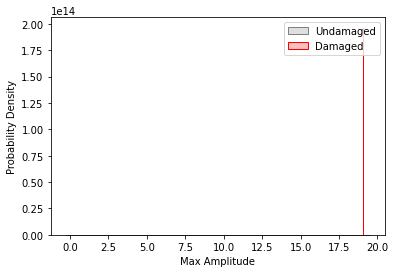

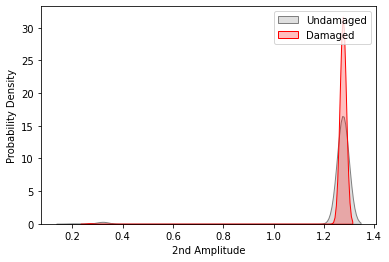

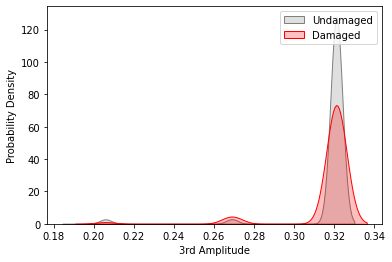

/Users/jasonpayne/miniforge3/envs/work/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


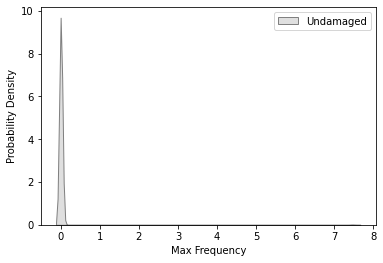

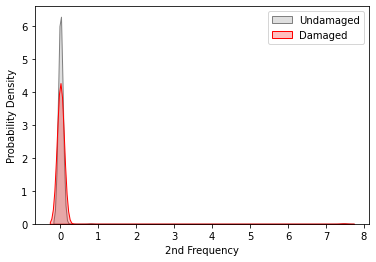

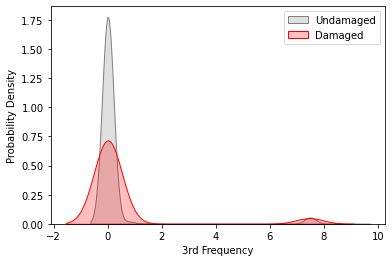

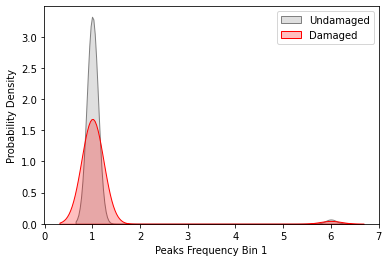

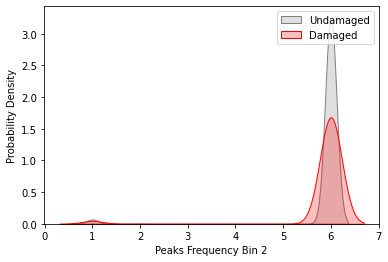

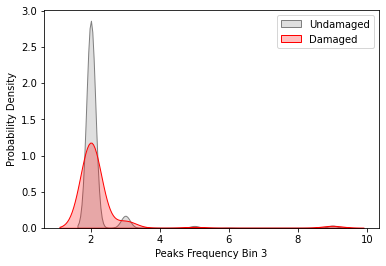

In [25]:
import seaborn as sns
# Plot and compare distributions
for lab in df_damaged.drop(['target'], axis = 1).columns:
    sns.kdeplot(df_undamaged[lab], color='grey', shade=True) 
    sns.kdeplot(df_damaged[lab], color='red', shade=True) 
    plt.legend(labels=["Undamaged","Damaged"])
    plt.xlabel(feature_dict.get(lab))
    plt.ylabel('Probability Density')
    plt.show()

**Note:** From the above plots, entropy may be the only useful feature.

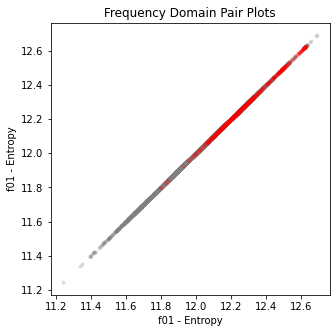

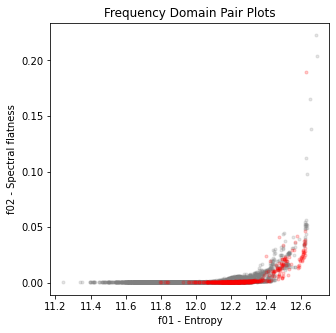

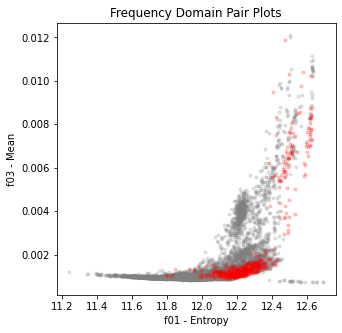

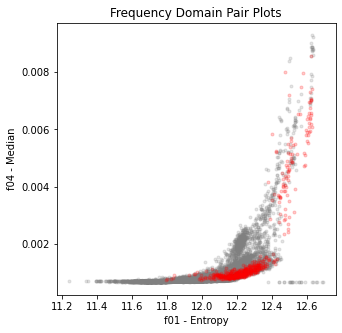

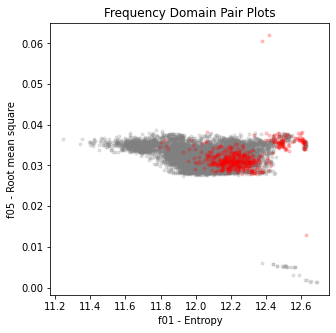

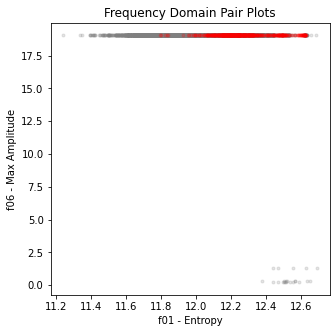

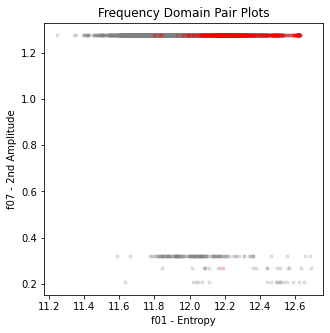

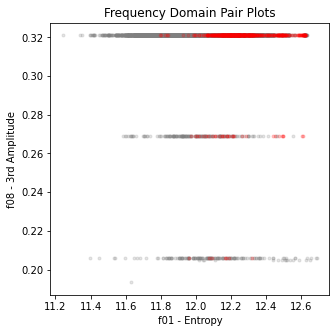

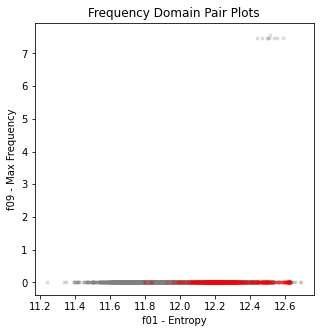

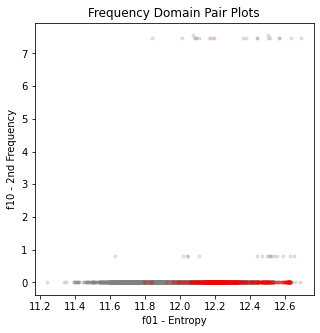

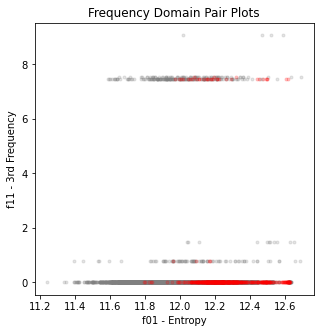

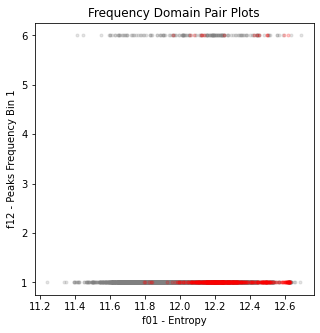

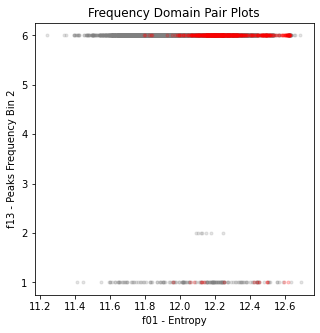

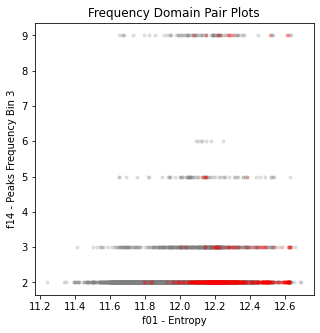

In [26]:
for lab in df_damaged.drop(['target'], axis = 1).columns:
    fig, ax = plt.subplots(figsize = (5, 5))
    plt.plot(df_undamaged['f01'], df_undamaged[lab], '.', color='gray', alpha = 0.2, zorder=1, label='Undamaged', )
    plt.plot(df_damaged['f01'], df_damaged[lab], '.', color='red', alpha = 0.2, zorder=2, label='Damaged', )
    plt.title('Frequency Domain Pair Plots')
    plt.xlabel('f01 - Entropy')
    plt.ylabel(f'{lab} - {feature_dict.get(lab)}')
    #plt.legend()
    plt.show()

### Standardise Data

In [27]:
# Standardize the features
data = df.drop(['target'], axis = 1)
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data)
data.index = df.index
data['target'] = df['target']

### Preliminary Modelling Checks

### Unsupervised Anomaly Detection - One-class SVM
- Train on undamaged data
- Test on hold-out damaged data

In [28]:
df_undamaged = data.loc[(data['target']==0)]
df_damaged = data.loc[(data['target']==1)]

In [29]:
# Train a one-class SVM 
# nu = contamination 
df_train = df_undamaged.drop(['target'], axis=1)
svm_model =  OneClassSVM(nu = 0.1)
svm_model.fit(pd.DataFrame(df_train))

OneClassSVM(nu=0.1)

In [30]:
# Predict for train set 
preds = pd.Series(svm_model.predict(df_train))
svm_out = pd.DataFrame({'signature':df_train.index, 'Prediction':preds})
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['signature']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly0 = svm_aly

819 out of 8187 (10.0%)


In [31]:
# Predict for test set
df_test = df_damaged.drop(['target'], axis=1)
preds = pd.Series(svm_model.predict(df_test))
svm_out = pd.DataFrame({'signature':df_test.index, 'Prediction':preds})
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['signature']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly1 = svm_aly

147 out of 525 (28.0%)


### Supervised Classification - Logistic Regression
- Assess model performance using cross validation
- No over-sampling for now (or creation of hold-out test set)

In [32]:
X_sig = df.drop(['target'], axis = 1).to_numpy()
y_sig = df.target.to_numpy()

In [37]:
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef,make_scorer
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV

In [38]:
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler()
X_sig = scaler.fit_transform(X_sig)

In [39]:
#pd.DataFrame(X_sig).describe()

In [40]:
# split into train and CV data
n_splits = 5
splits = list(sklearn.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True).split(X_sig, y_sig))

models = []
scores = np.zeros(n_splits)

print('Training...')
print('MCC training & cv') # MCC = Matthews Correlation Coefficient

alphas = [10**i for i in range(0, 5)]
cv_mccs = []

# Vary C as alpha
# C is a positive floating-point number (1.0 by default) that defines the relative strength of regularization. 
# Smaller values indicate stronger regularization.
for alpha in alphas:
    print('for alpha = {}'.format(alpha))
    for i, (idx_train, idx_cv) in enumerate(splits):

        #train and cv split
        X_train = X_sig[idx_train, :]
        y_train = y_sig[idx_train]

        X_cv = X_sig[idx_cv, :]
        y_cv = y_sig[idx_cv]

        #initalizing and fitting the model
        model = LogisticRegression(C=alpha,max_iter=8000)
        model.fit(X_train, y_train.astype(float))

        #prediction
        y_predict_train = model.predict(X_train)
        y_predict_cv = model.predict(X_cv)
        
        #calculating mcc metric
        score_train = matthews_corrcoef(y_train, y_predict_train)
        score_cv = matthews_corrcoef(y_cv, y_predict_cv)

        #storing the models
        models.append(model)
        scores[i] = score_cv
        
        print(sklearn.metrics.confusion_matrix(y_cv, y_predict_cv))
        print('Recall: ', round(sklearn.metrics.recall_score(y_cv, y_predict_cv), 2))
        print('Precision: ', round(sklearn.metrics.precision_score(y_cv, y_predict_cv), 2))
        
        #printing the train and cross validation mcc score
        print('%d %.3f %.3f' % (i, score_train, score_cv))

    # average of all the scores
    print('\nCV MCC scores %.3f ± %.3f' % (np.mean(scores), np.std(scores)))
    cv_mccs.append(np.mean(scores))
    print()

Training...
MCC training & cv
for alpha = 1
[[1636    2]
 [  96    9]]
Recall:  0.09
Precision:  0.82
0 0.224 0.254
[[1633    5]
 [  93   12]]
Recall:  0.11
Precision:  0.71
1 0.183 0.269
[[1627   10]
 [  98    7]]
Recall:  0.07
Precision:  0.41
2 0.213 0.147
[[1625   12]
 [  96    9]]
Recall:  0.09
Precision:  0.43
3 0.212 0.171
[[1633    4]
 [  98    7]]
Recall:  0.07
Precision:  0.64
4 0.226 0.193

CV MCC scores 0.207 ± 0.047

for alpha = 10
[[1636    2]
 [  96    9]]
Recall:  0.09
Precision:  0.82
0 0.227 0.254
[[1631    7]
 [  93   12]]
Recall:  0.11
Precision:  0.63
1 0.181 0.252
[[1627   10]
 [  98    7]]
Recall:  0.07
Precision:  0.41
2 0.210 0.147
[[1625   12]
 [  95   10]]
Recall:  0.1
Precision:  0.45
3 0.212 0.187
[[1631    6]
 [  97    8]]
Recall:  0.08
Precision:  0.57
4 0.220 0.193

CV MCC scores 0.207 ± 0.041

for alpha = 100
[[1636    2]
 [  96    9]]
Recall:  0.09
Precision:  0.82
0 0.227 0.254
[[1631    7]
 [  93   12]]
Recall:  0.11
Precision:  0.63
1 0.181 0.252
[[

### Unsupervised Anomaly Detection - PCA

In [41]:
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from matplotlib import gridspec
from matplotlib.pyplot import figure

# Define the PCA model (all compoments)
n_comps = 5 # How many dimensions you want to reduce to
pca = PCA(n_components = n_comps, svd_solver = 'full')

# Compute PCA components for the training set
X_train_PCA = pca.fit_transform(df_undamaged)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = df_train.index

# Project the test data onto the PCA space
X_test_PCA = pca.transform(df_damaged)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = df_test.index

# Print the explained variance
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress=True) 
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.252 0.183 0.133 0.124 0.07 ]


/Users/jasonpayne/miniforge3/envs/work/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/jasonpayne/miniforge3/envs/work/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


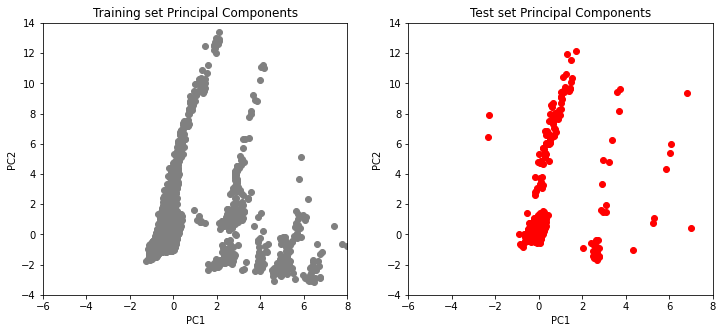

In [42]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
gs = gridspec.GridSpec(1, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:, 1], color = 'grey')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.set_xlim(-6, 8)
ax0.set_ylim(-4, 14)
ax0.set_title('Training set Principal Components')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test_PCA.loc[:, 0], X_test_PCA.loc[:, 1], color = 'red')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_xlim(-6, 8)
ax1.set_ylim(-4, 14)
ax1.set_title('Test set Principal Components')

plt.show()

### Unsupervised Anomaly Detection - Clustering

In [43]:
from sklearn.cluster import KMeans

In [44]:
# Standardize the features
scaler1 = preprocessing.StandardScaler()
np_scaled = scaler1.fit_transform(X_sig)
data = pd.DataFrame(np_scaled)

# Reduce to 2 PCA features
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# Standardize these 2 new features
scaler2 = preprocessing.StandardScaler()
np_scaled = scaler2.fit_transform(data)
data = pd.DataFrame(np_scaled, columns = ['PC1', 'PC2'])

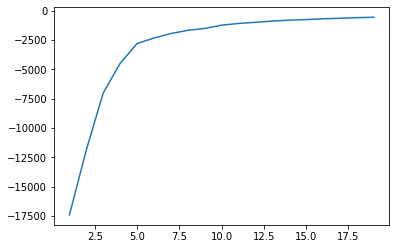

In [45]:
# Calculate with different numbers of centroids & plot the loss (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i, random_state=1234).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [46]:
# Choose 15 centroids & add these data to the base dataframe
#kmeans_model = KMeans(n_clusters=15, random_state=1234).fit(data)
df_set = pd.DataFrame(X_sig)
if 'df' in globals(): del df
df = df_set.copy(deep=True)
df['cluster'] = kmeans[14].predict(data)
df.reset_index(drop = True, inplace = True)
df['principal_feature1'] = pd.Series(data['PC1'])
df['principal_feature2'] = pd.Series(data['PC2'])
df['cluster'].value_counts()

0     2964
5     2117
11    1385
10     918
1      523
3      200
9      194
12     127
4      123
7       69
8       56
2       15
6       14
13       4
14       3
Name: cluster, dtype: int64

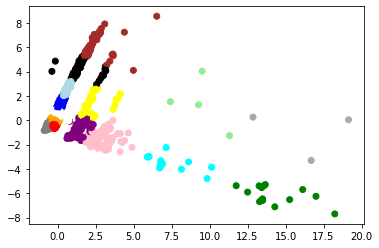

In [47]:
# Plot the different clusters with the 2x PCA component features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [48]:
# Create a dataframe of cluster centroid coordinates
x_coords = []
y_coords = []
for p in range(15):
    x_coords.append(kmeans[14].cluster_centers_[p][0])
    y_coords.append(kmeans[14].cluster_centers_[p][1])    
    
coords_cl = pd.DataFrame({
    'cluster':range(0, 15, 1),
    'x_coords':pd.Series(x_coords),
    'y_coords':pd.Series(y_coords),
})

In [49]:
# Create a dataframe of PCs, cluster, status, etc. and join with the coords
backdrop_chan = 'f01'
examine_cl = pd.DataFrame({        
    backdrop_chan:pd.Series(df_damaged[0]),
    'PC1':pd.Series(df.principal_feature1),
    'PC2':pd.Series(df.principal_feature2),
    'cluster':pd.Series(df.cluster)
})
examine_cl = pd.merge(examine_cl, coords_cl, how='left', on='cluster')

In [50]:
"""
Create a list of distances between each point & its distance to cluster centroid
Use Euclidean distance 
d = √((x_2-x_1)²+(y_2-y_1)²) 
"""
calc_dists = []
for d in range(len(examine_cl)):
    x1 = examine_cl.PC1.iloc[d]
    x2 = examine_cl.x_coords.iloc[d]
    y1 = examine_cl.PC2.iloc[d]
    y2 = examine_cl.y_coords.iloc[d]
    calc_dists.append(np.sqrt(np.square(x2-x1) + np.square(y2-y1)))

In [51]:
# Assign an oultlier fraction & calculate prediction based on threshold
outliers_fraction = 0.1
examine_cl = examine_cl.assign(distance = calc_dists)
number_of_outliers = int(outliers_fraction * len(examine_cl))
calc_threshold = examine_cl.distance.nlargest(number_of_outliers).min()
print(f'Distance threshold is {round(calc_threshold, 3)}')
examine_cl = examine_cl.assign(threshold = calc_threshold)
examine_cl = examine_cl.assign(prediction = (examine_cl.distance > examine_cl.threshold).astype(int))

Distance threshold is 0.322


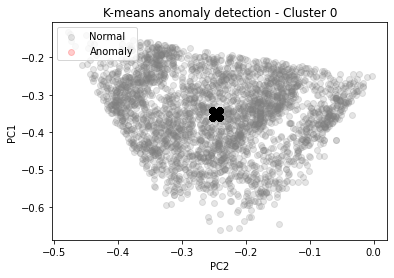

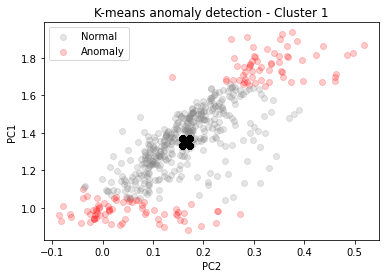

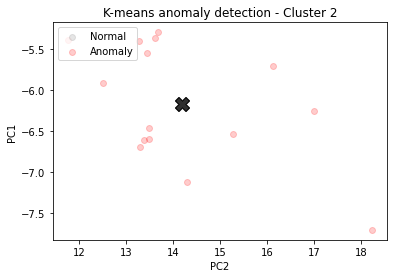

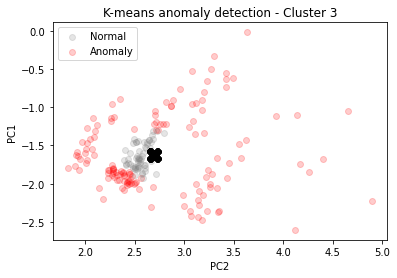

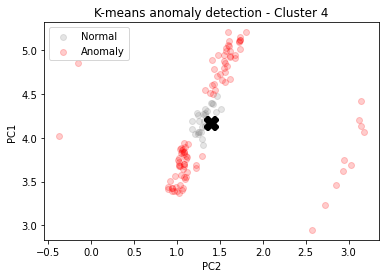

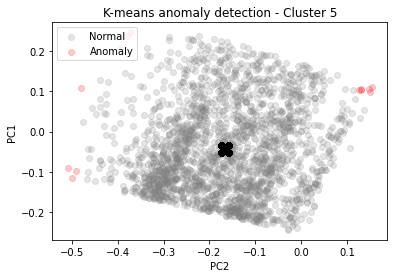

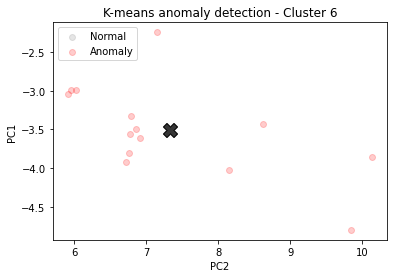

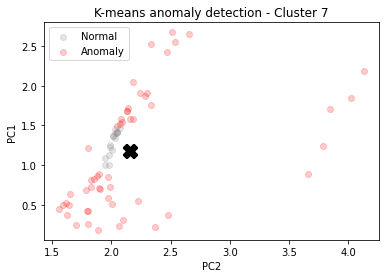

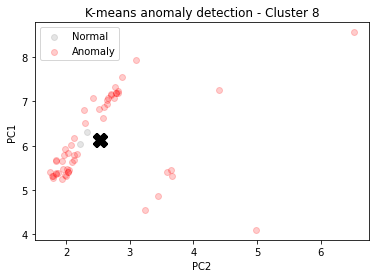

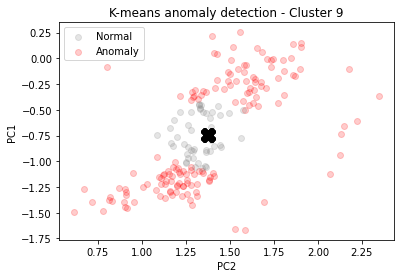

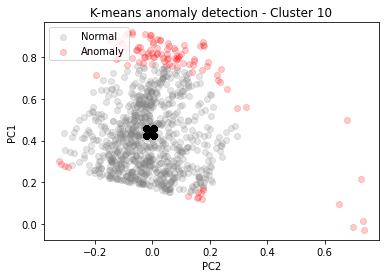

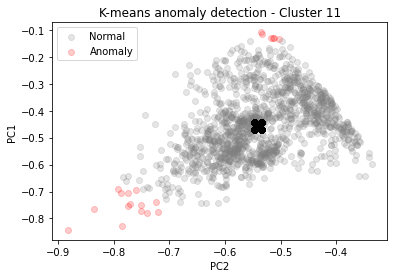

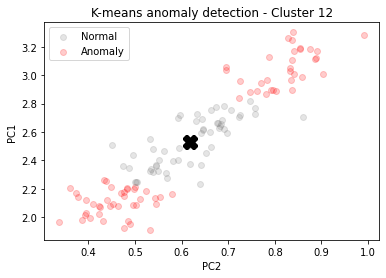

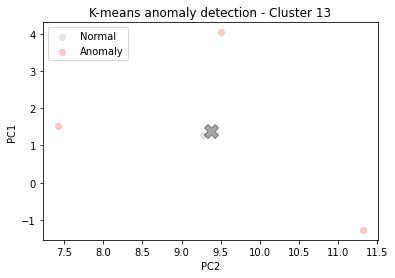

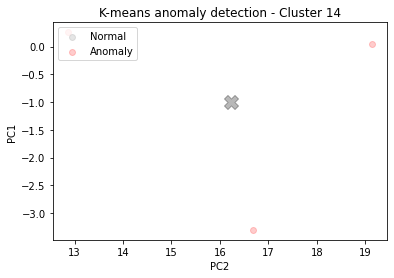

In [52]:
# Plot each cluster
for cl in range(15):    
    tmp_0 = examine_cl[(examine_cl.prediction == 0) & (examine_cl.cluster == cl)]
    tmp_1 = examine_cl[(examine_cl.prediction == 1) & (examine_cl.cluster == cl)]
    # Visualisation of anomaly with cluster view
    fig, ax = plt.subplots()

    # Now plot
    ax.scatter(tmp_0.PC1, tmp_0.PC2, zorder = 2, alpha = 0.2, c = 'grey', label = 'Normal')
    ax.scatter(tmp_1.PC1, tmp_1.PC2, zorder = 1, alpha = 0.2, c = 'red', label = 'Anomaly')
    ax.scatter(tmp_0.x_coords, tmp_0.y_coords, zorder = 3, marker = 'X', s = 200, alpha = 0.1, c = 'black')
    ax.scatter(tmp_1.x_coords, tmp_1.y_coords, zorder = 3, marker = 'X', s = 200, alpha = 0.1, c = 'black')
    plt.ylabel("PC1")
    plt.xlabel("PC2")
    plt.title(f'K-means anomaly detection - Cluster {cl}')
    ax.legend(loc='upper left') 
    plt.show()

/Users/jasonpayne/miniforge3/envs/work/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


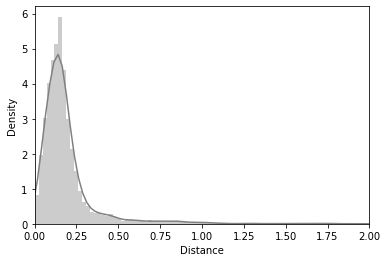

In [53]:
# Plot distribution of distances
plt.figure()
sns.distplot(examine_cl.distance, bins = 200, kde = True, color = 'grey');
plt.xlim([0.0, 2])
plt.xlabel('Distance')
plt.show()

In [54]:
print(f'Selected anomaly percentage: {100 * outliers_fraction}%')
print('Selected threshold distance:', round(examine_cl.threshold.unique()[0], 3))

Selected anomaly percentage: 10.0%
Selected threshold distance: 0.322


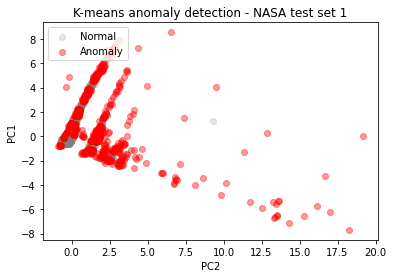

In [55]:
# Visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize = (6, 4))

# Now plot
ax.scatter(examine_cl[examine_cl.prediction == 0].PC1, examine_cl[examine_cl.prediction == 0].PC2, 
           zorder = 1, alpha = 0.2, c = 'grey', label = 'Normal')
ax.scatter(examine_cl[examine_cl.prediction == 1].PC1, examine_cl[examine_cl.prediction == 1].PC2, 
           zorder = 2, alpha = 0.4, c = 'red', label = 'Anomaly')
plt.ylabel("PC1")
plt.xlabel("PC2")
plt.title('K-means anomaly detection - NASA test set 1')
ax.legend(loc = 'upper left')  
plt.show()

In [56]:
examine_cl.index = df_set.index

In [57]:
res_snap_cl = examine_cl.loc[examine_cl.index.isin(df_train.index),:]
# Check false positive rate (from the training data)
# This should cross check with contamination rate specified in SVM model (~0.5%)
cl_to = len(res_snap_cl['prediction'])
cl_fp = sum(res_snap_cl['prediction'] == 1)
cl_tn = sum(res_snap_cl['prediction'] == 0)
print(f'False positives is {cl_fp} ({round(100*cl_fp/cl_to, 2)}%)')
print(f'Check {"{:,}".format(cl_to)} (total rows) = {"{:,}".format(cl_fp+cl_tn)} (FP + TN count): {cl_to == (cl_fp+cl_tn)}')

False positives is 773 (9.44%)
Check 8,187 (total rows) = 8,187 (FP + TN count): True


In [58]:
res_snap_cl = examine_cl.loc[examine_cl.index.isin(df_test.index),:]
# Check false positive rate (from the training data)
# This should cross check with contamination rate specified in SVM model (~0.5%)
cl_to = len(res_snap_cl['prediction'])
cl_an = sum(res_snap_cl['prediction'] == 1)
cl_nn = sum(res_snap_cl['prediction'] == 0)
print(f'Anomaly point count is {cl_an} ({round(100*cl_an/cl_to, 2)}%)')
print(f'Check {"{:,}".format(cl_to)} (total rows) = {"{:,}".format(cl_an+cl_nn)} (FP + TN count): {cl_to == (cl_an+cl_nn)}')

Anomaly point count is 97 (18.48%)
Check 525 (total rows) = 525 (FP + TN count): True


**Note:** Very poor modelling performane in all cases.